Loading...
Done.


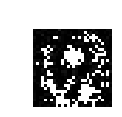

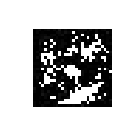

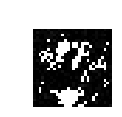

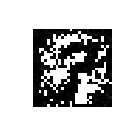

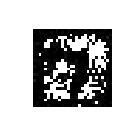

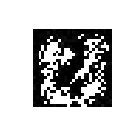

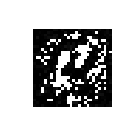

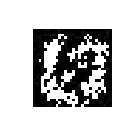

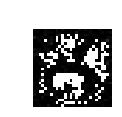

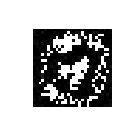

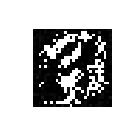

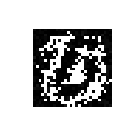

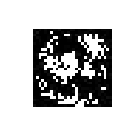

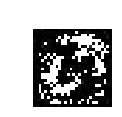

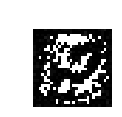

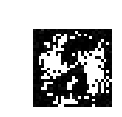

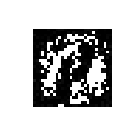

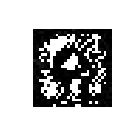

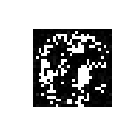

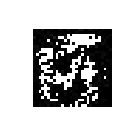

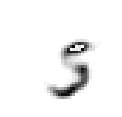

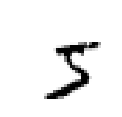

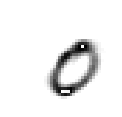

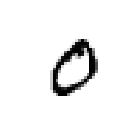

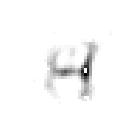

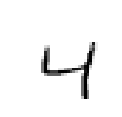

In [23]:
import time
import autograd.numpy as np
import mnist as mn
from autograd.optimizers import adam, rmsprop
from autograd import grad

def init_params(layer_widths, scale):
    """Contstructs a list of tuples (W,b) weight, bias"""
    params = []
    for i in range(len(layer_widths) - 1):
        params.append(
            (
                np.random.rand(layer_widths[i], layer_widths[i+1]) * scale, # weights
                np.random.rand(layer_widths[i+1]) * scale # bias
            )
        )
    
    return params

def evaluate_net(sample, params, max_depth=None):
    """Evalutes sample with network params"""
    inputs = sample
    for W,b in params[:max_depth]:
        outputs = np.add(np.dot(inputs, W), b)
        inputs = np.maximum(outputs, 0.0) # ReLU

    return inputs # Do I need to do a different operation at the output layer for autoencoder? Need to enforce sparsity too

def auto_enc_loss(batch, params):
    """Takes array of inputs"""
    error = 0.0

    prediction = evaluate_net(batch, params)
    error += np.mean((batch - prediction) ** 2) 

    return error / len(train_data)
    #return np.sum(prediction)
    
def train(train_data, test_data, layer_widths, step_size, num_epochs, batch_size):
    num_batches = int(np.ceil(len(train_data) / batch_size))
    num_iters = num_batches * num_epochs
    print("num_batches: ", num_batches)
    print("num_iters: ", num_iters)

    def objective(params, iteration):
        idx = iteration % num_batches
        chunk = slice(idx * batch_size, (idx + 1) * batch_size)
        return auto_enc_loss(train_data[chunk], params)

    def print_perf(params, iteration, gradient):
        if iteration % num_batches == 0:
            print(100.0 * iteration / num_iters, '% done')
            print('Training error: ', auto_enc_loss(train_data, params))
            print('Test error: ', auto_enc_loss(test_data, params))
    
    objective_grad = grad(objective)
    params = init_params(layer_widths, 0.1)
    
    optimized_params = adam(
        grad=objective_grad,
        init_params=params,
        step_size=step_size,
        num_iters=num_iters,
        callback=print_perf
    )
    
    return optimized_params

def compute_max_activation_for_unit(params, depth, index, step_size, num_iters):
    input_size = len(params[0][0])
    max_activation = input_size * 1.0
    def objective(image, iteration):
        
        activation = evaluate_net(np.minimum(np.maximum(image, 0.0), 1.0), params, depth)[index]
        return -activation
    
    def print_perf(image, iteration, gradient):
        return
        if (iteration + 1) % (num_iters//5) == 0:
            print(100.0 * iteration / num_iters, '% done')
            print('Activation: ', -objective(image, iteration))
            mn.show(mn.from_vec(image))

    init_image = np.random.rand(input_size) * 0.1
                                
    objective_grad = grad(objective)
                                
    result = rmsprop(
        grad=objective_grad,
        init_params=init_image,
        step_size=step_size,
        num_iters=num_iters,
        callback=print_perf
    )
    
#    print_perf()
    return result
    
def time_call(f):
    start = time.time()
    f()
    return time.time() - start

def load_params(path):
    with open("./mnist_auto_enc_params.bin", 'rb') as f:
        return np.load(f)

if __name__ == '__main__':
    print("Loading...")
    trn_samp = list(mn.read(dataset='training', path='./mnist'))
    test_samp = list(mn.read(dataset='testing', path='./mnist'))
    train_data = np.array([mn.to_vec(samp[1]) for samp in trn_samp])
    test_data = np.array([mn.to_vec(samp[1]) for samp in test_samp])
    print("Done.")
    
    in_size = 28 * 28
    layer_widths = [in_size, 20, in_size]

    param_scale = 0.1
    batch_size = 256
    num_epochs = 25
    step_size = 0.001

    #params = init_params(layer_widths, param_scale)
    params = load_params("./mnist_auto_enc_params.bin")
    
    for i in range(20):
        image = compute_max_activation_for_unit(params, 1, i, 0.001, 1000)
        mn.show(mn.from_vec(image))

#     print("Training")
#     params = train(train_data, test_data, layer_widths, step_size, num_epochs, batch_size)
#     with open("./mnist_auto_enc_params.bin", 'wb') as f:
#         np.save(f, params)

    for i in range(3):
        output = evaluate_net(train_data[i], params)
        mn.show(mn.from_vec(output))
        mn.show(mn.from_vec(train_data[i]))
        print("")

    

